In [1]:
import os
from pathlib import Path

path_cwd = '/nvme/wangding/Desktop/tsim/tsim'
os.chdir(Path(path_cwd).absolute())
os.getcwd()

'/nvme/wangding/Desktop/tsim/tsim'

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from pathlib import Path
from graph.load import load_graph
from eval import *
from graph.process import generate_unique_node_id
import pandas as pd
import os
#import cv2
import pickle
import torch
from matplotlib.pyplot import figure
import math
import numpy as np
plt.style.use('default')
from sklearn.preprocessing import MinMaxScaler
import re
import numpy as np

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import re

import glob
import pickle
from collections import defaultdict

In [3]:
exp_dir = Path(path_cwd).resolve().parent / "experiment"
exp_dir

PosixPath('/nvme/wangding/Desktop/tsim/experiment')

In [4]:
training_step = 400
pred_step = 5
prev_step = 20
case =  "traci_tls"
test = "test500"
out = "out_dim_100_n_heads_4_n_layer_4_pred_step_5"

sim_feat = load_data(exp_dir,case,test,out,training_step,pred_step)

In [20]:
real_data_dir = exp_dir / case / "data" / test / "test_data"
train_data_dir = exp_dir / case  / "data" / test / "train_data"
node_all = pd.read_csv(train_data_dir / "node_all.csv")
node_id_dict = generate_unique_node_id(node_all)

real_struc, real_feat, node_id_dict, scalers =  load_graph(real_data_dir,training_step-prev_step,training_step+pred_step*10,node_id_dict)

In [21]:
sim_feat = unscale_feat(sim_feat, scalers)
real_feat = unscale_feat(real_feat, scalers)

In [22]:
real_feat['lane'][0]

{'length': tensor([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
         500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]),
 'vehicles': tensor([ 8.0843,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,
         10.1054, 10.1054, 10.1054, 10.1054, 10.1054, 10.1054, 10.1054, 10.1054,
         10.1054, 10.1054, 10.1054, 12.1265, 12.1265, 12.1265, 12.1265, 12.1265,
         14.1476, 14.1476, 14.1476, 14.1476, 14.1476, 12.1265, 12.1265, 12.1265,
         12.1265, 12.1265, 10.1054, 10.1054, 10.1054,  8.0843, 10.1054, 10.1054,
         10.1054,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,  8.0843,
          

### 2. Feat comparison

In [23]:
def plot_feat(real_feat,sim_feat,node_type,node_id,feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    feat_sim = get_feat_df(sim_feat, node_type, node_id, feat_name)
    feat_sim = feat_sim[feat_sim['time'] != 0]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
    ax.plot(feat_real['time'],feat_real[feat_name+str(node_id)], label = "real")
    ax.plot(feat_sim['time'],feat_sim[feat_name+str(node_id)], linestyle='--',  marker='o',
        markersize=2, label = "sim")
    ax.set_xlabel("steps")
    ax.set_ylabel(feat_name)
    #ax.set_ylim(0,1)
    ax.set_title( feat_name+' of '+ node_type+'_'+str(node_id))
    ax.legend()

In [24]:

common_keys = list(real_feat['veh'].keys() & sim_feat['veh'].keys())

/tmp/ipykernel_126971/3897183209.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))


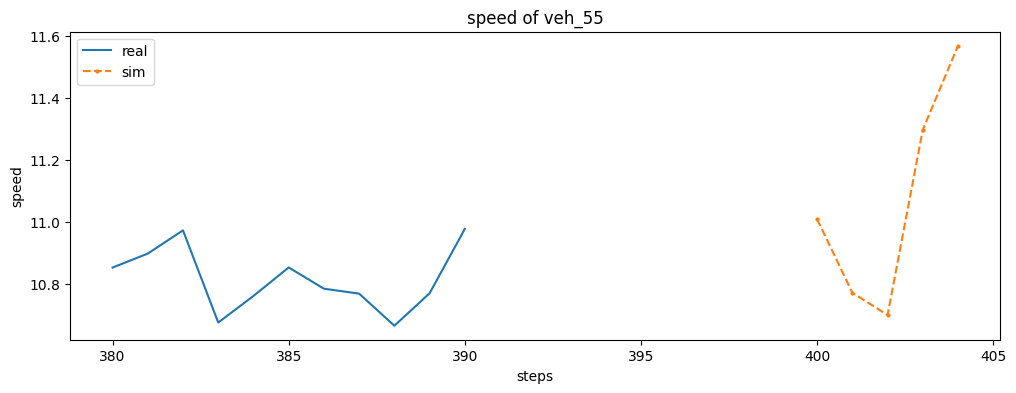

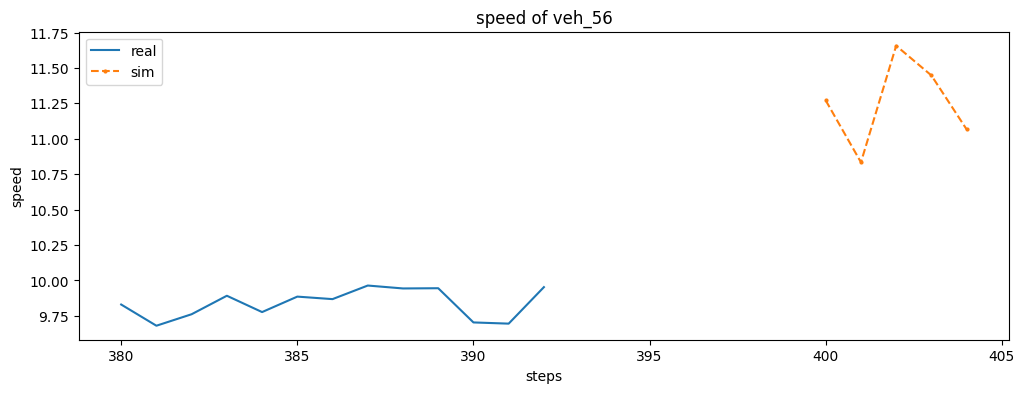

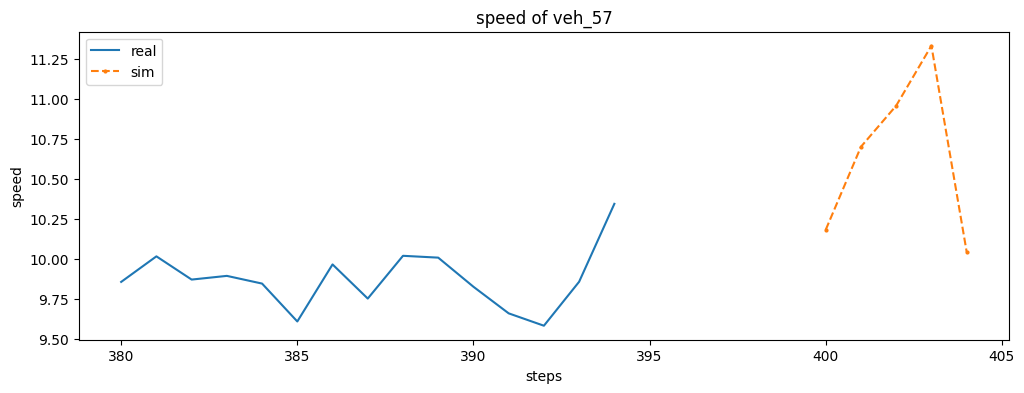

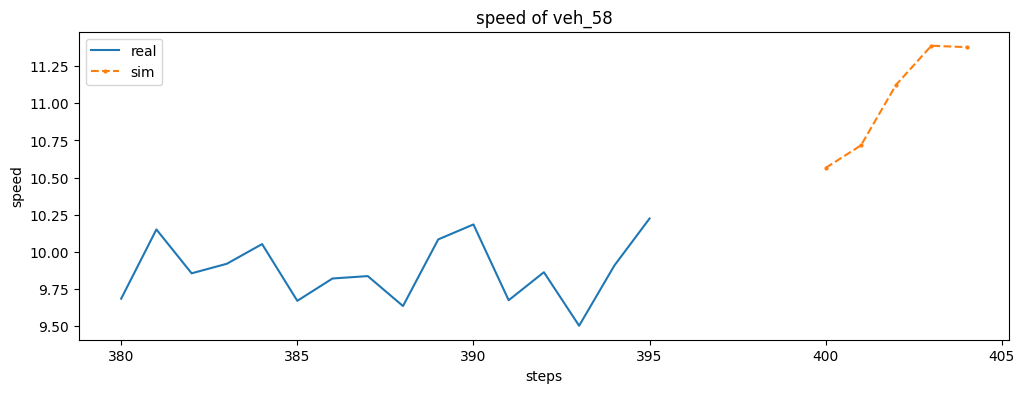

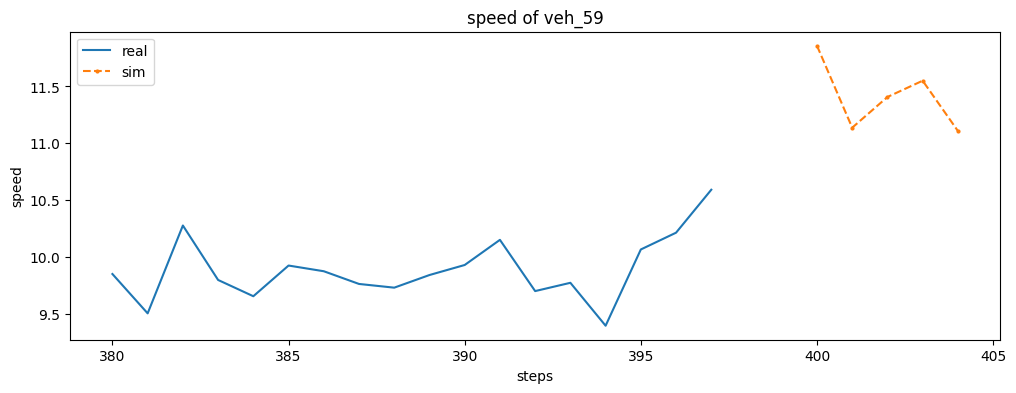

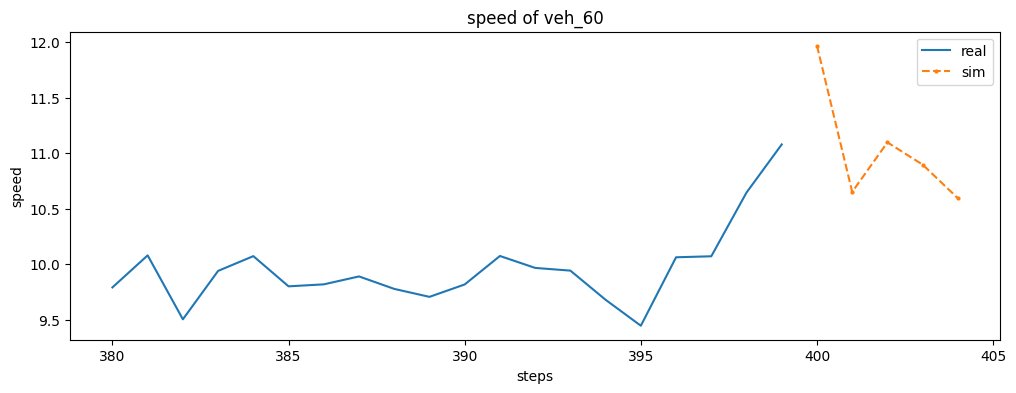

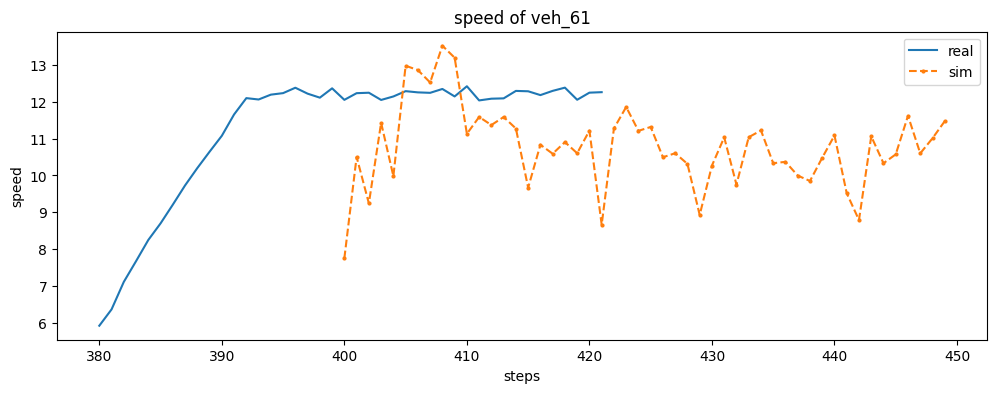

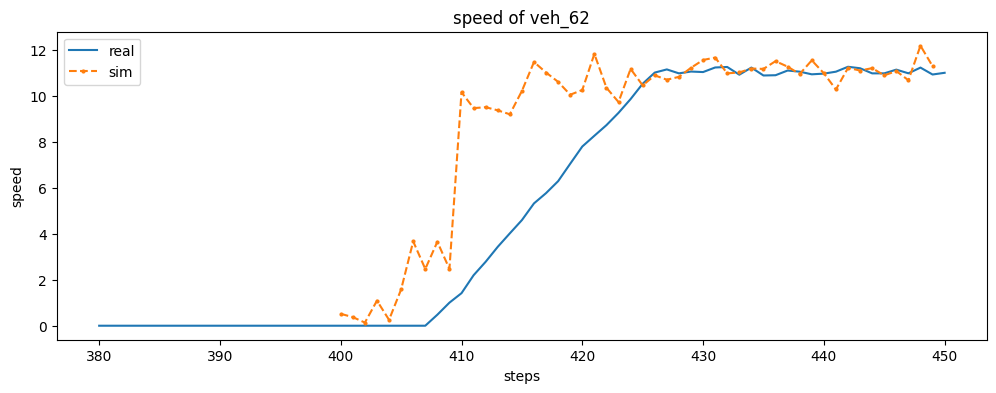

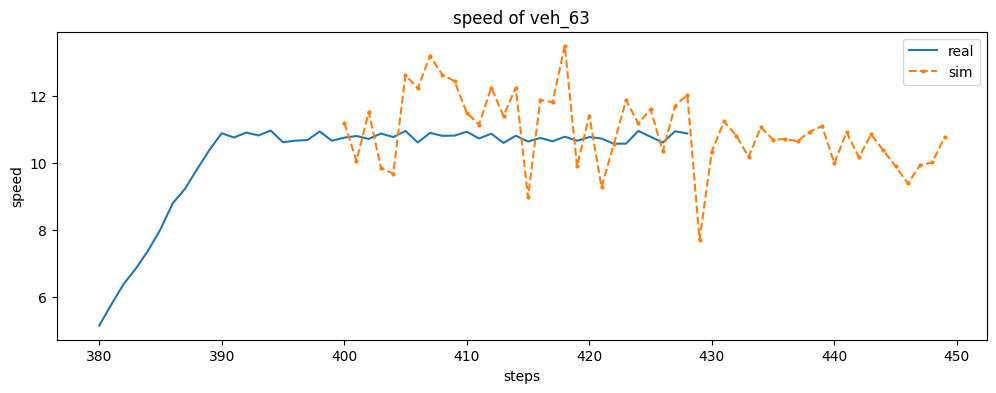

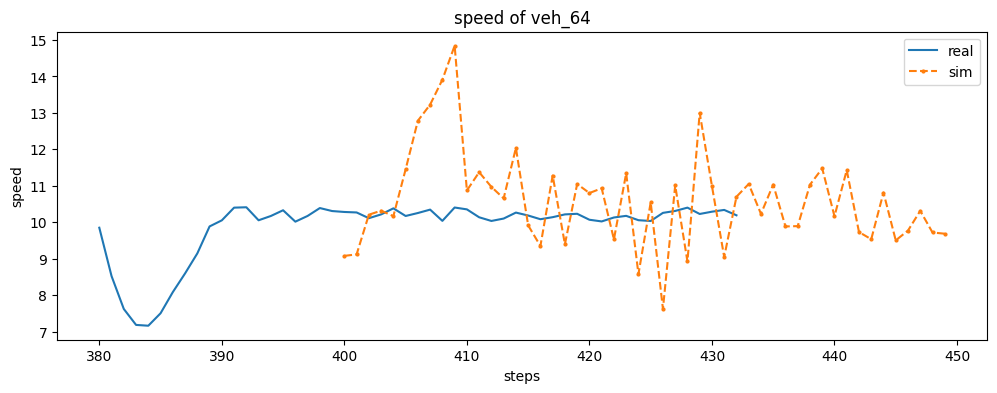

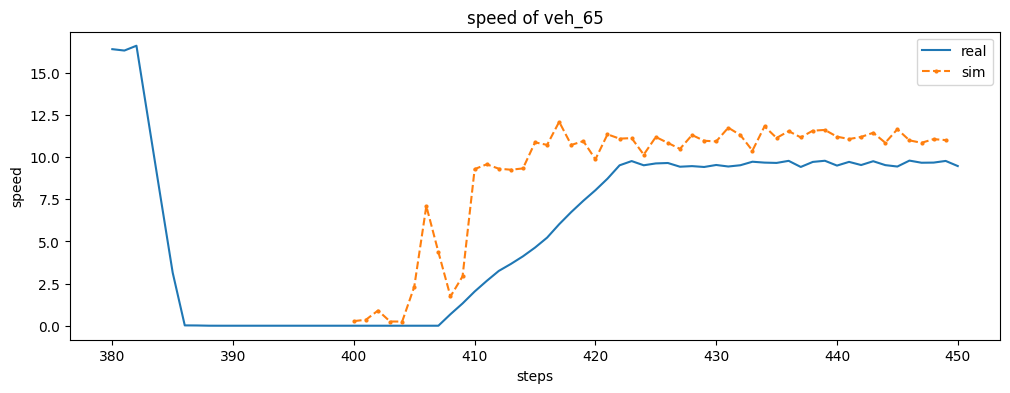

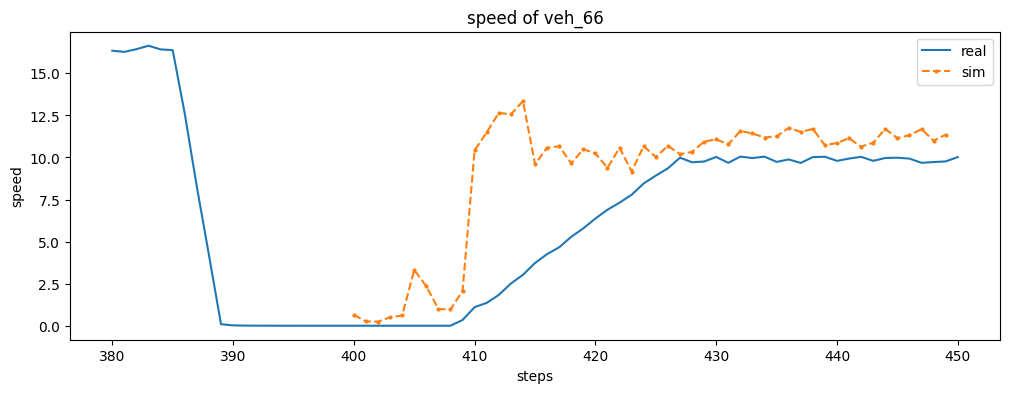

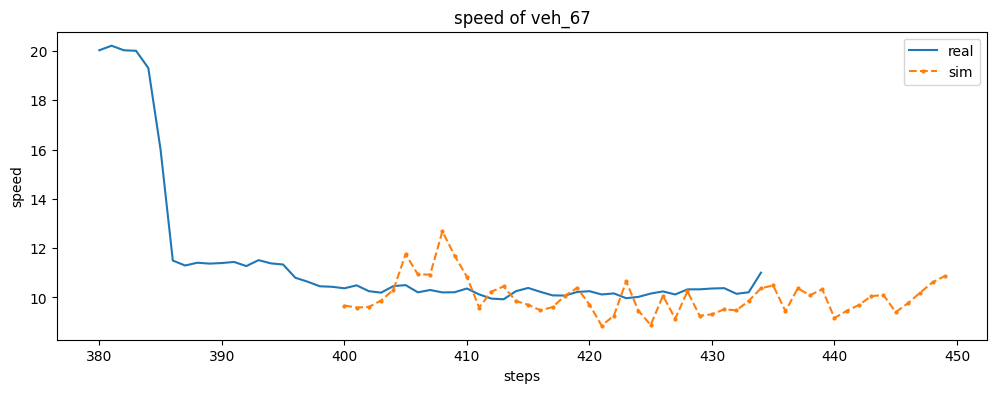

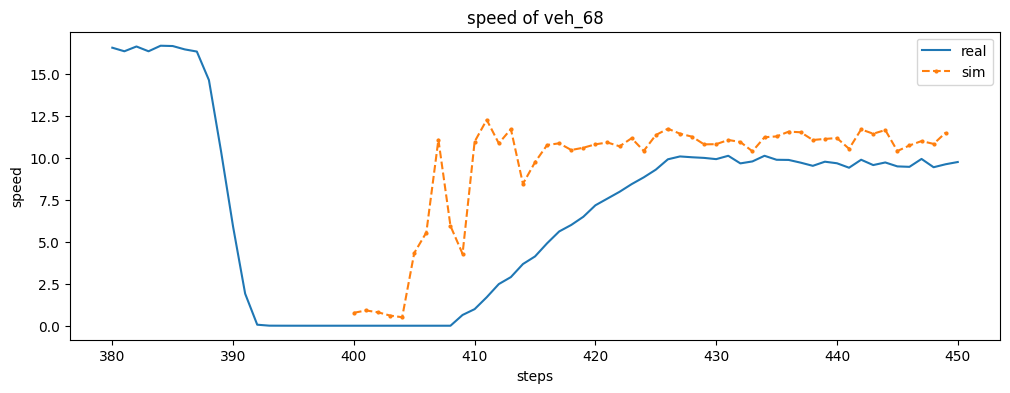

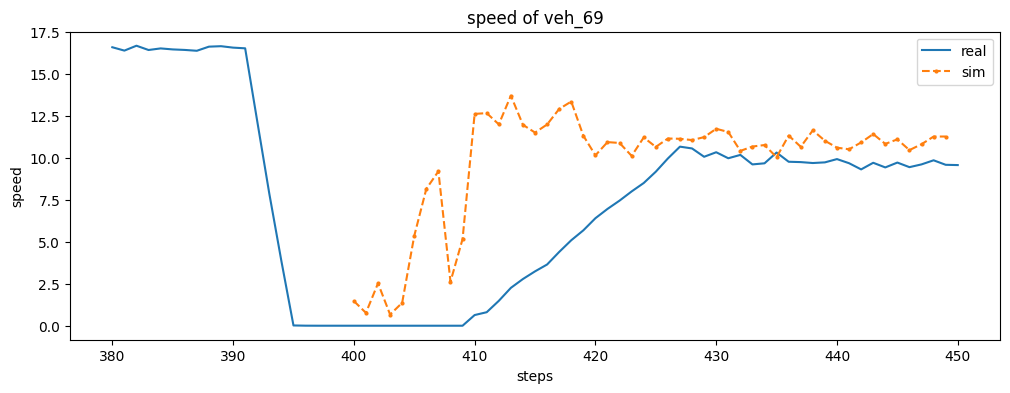

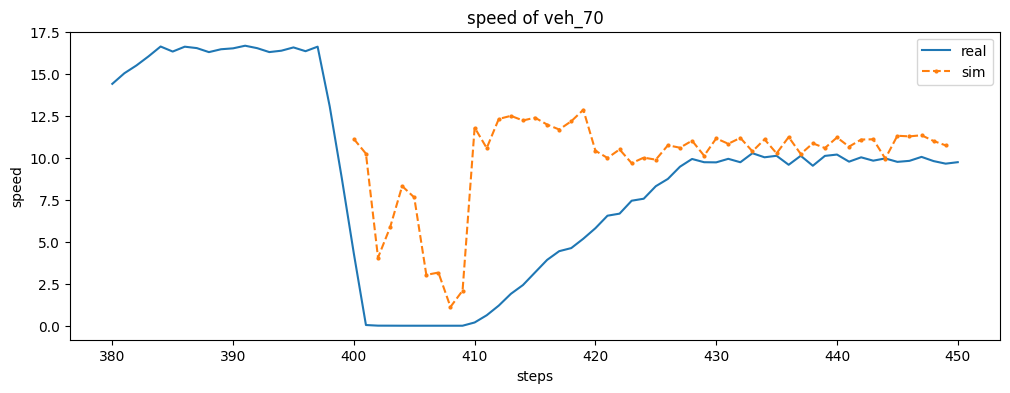

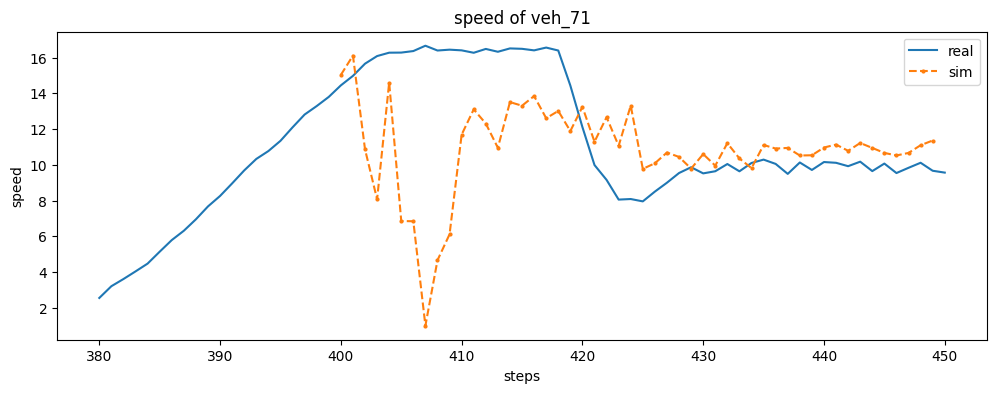

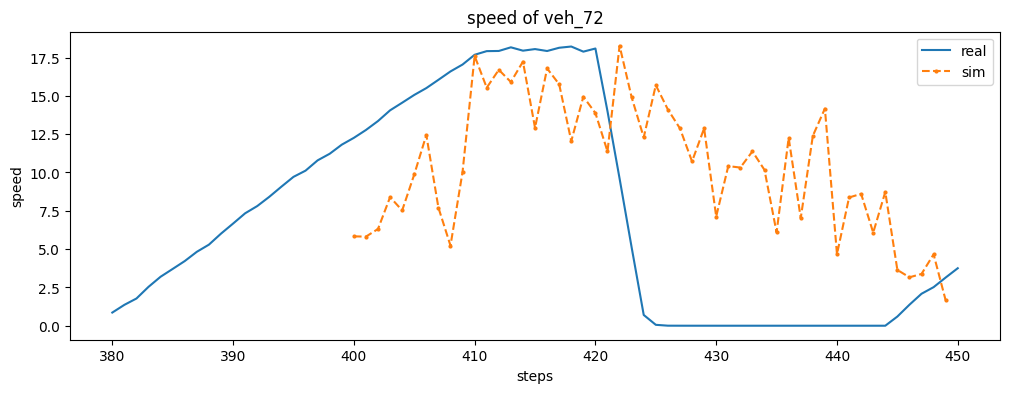

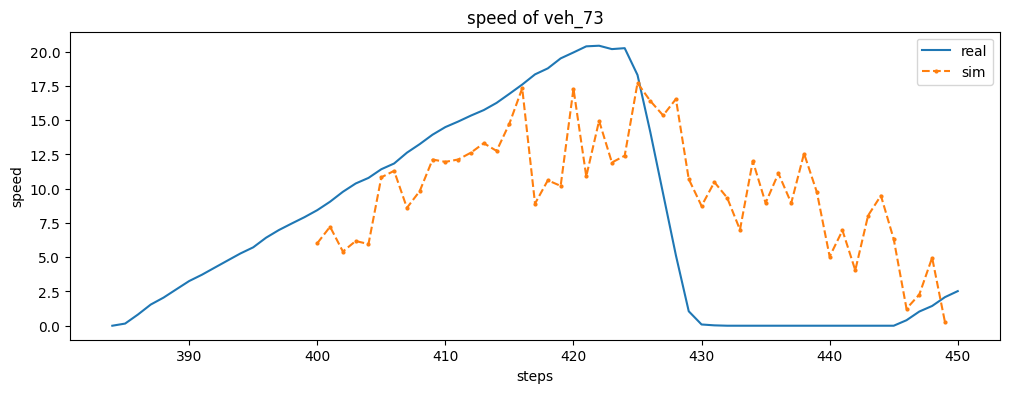

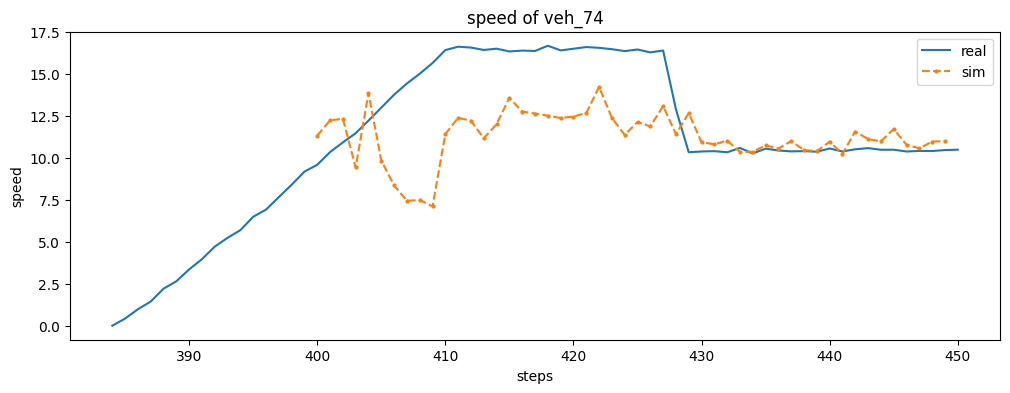

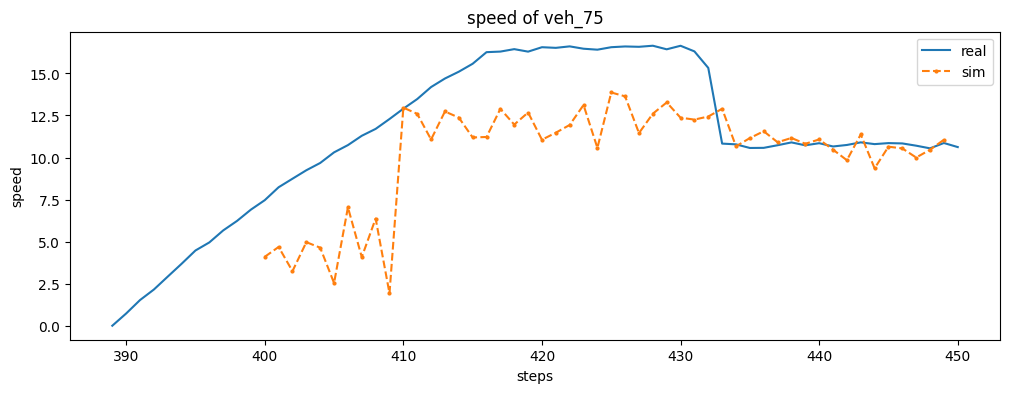

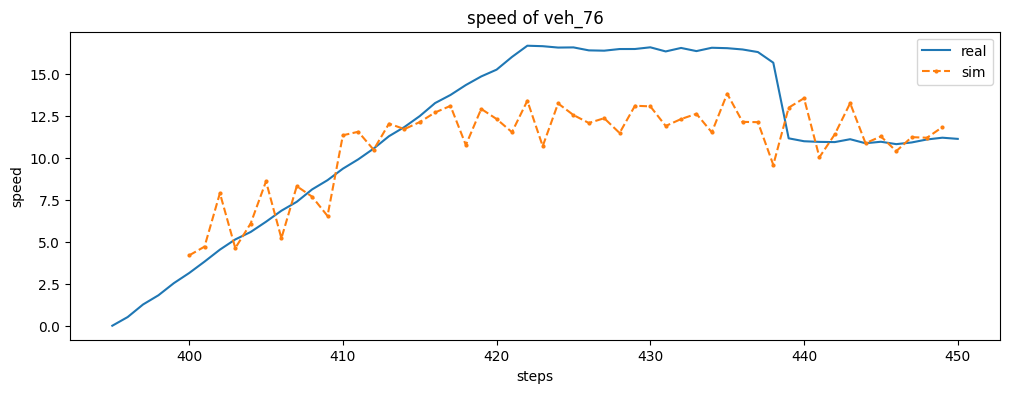

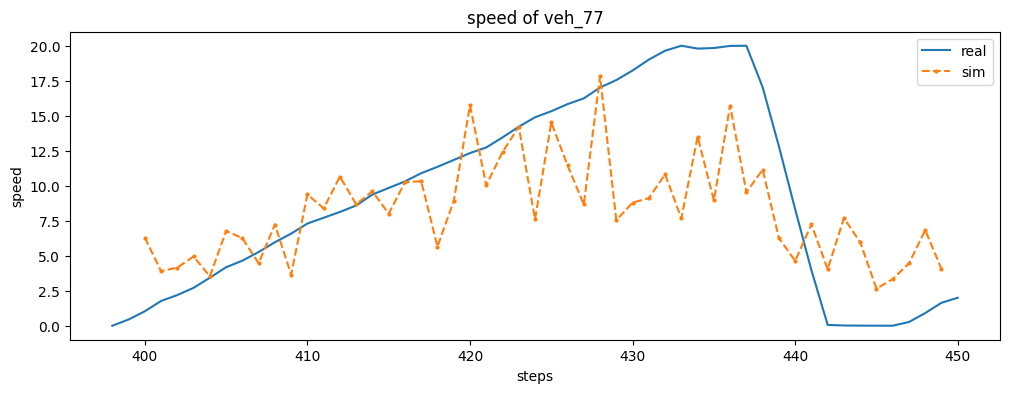

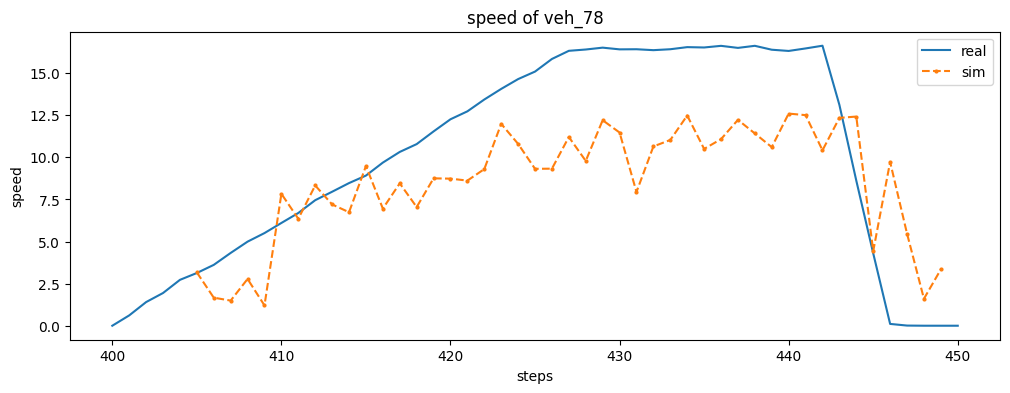

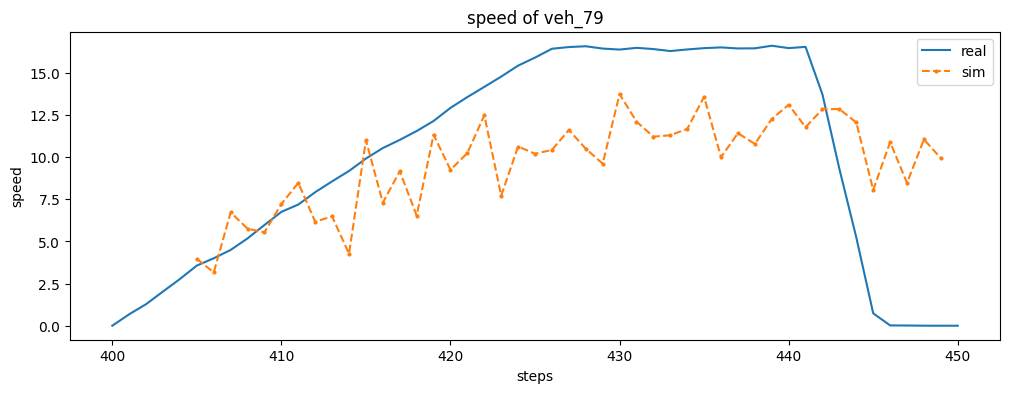

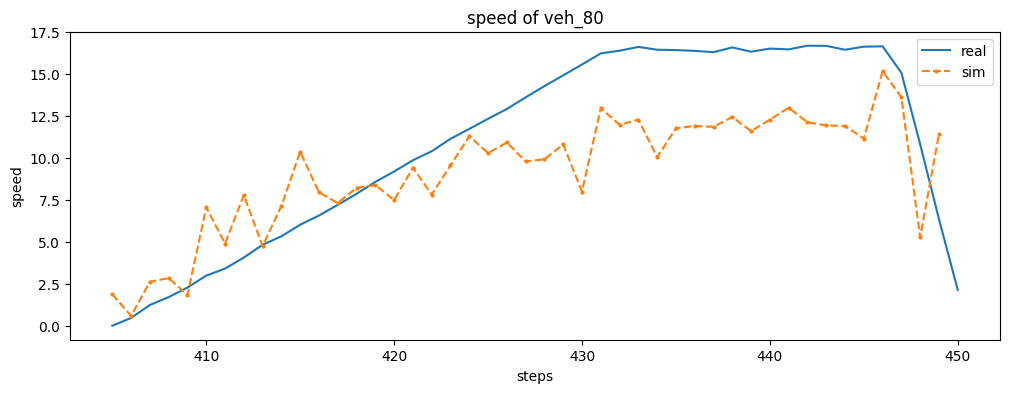

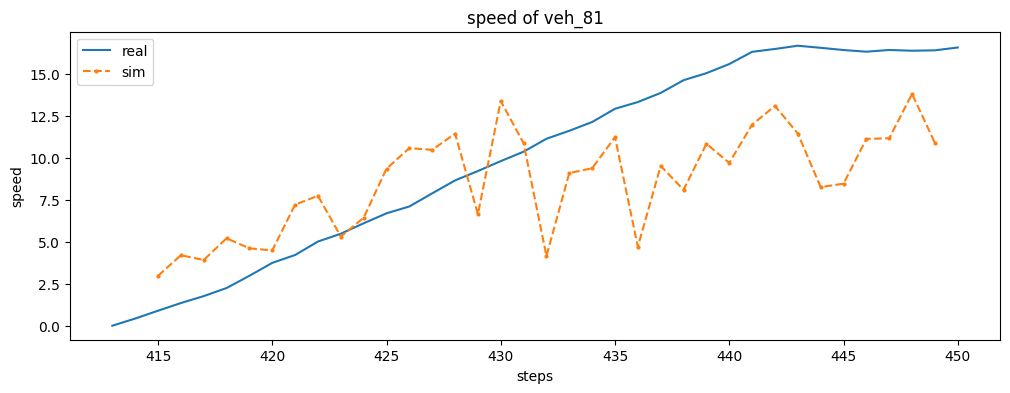

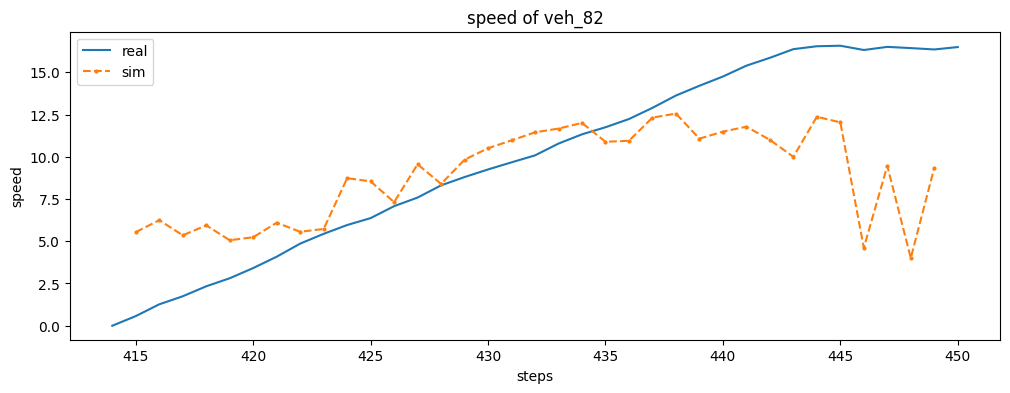

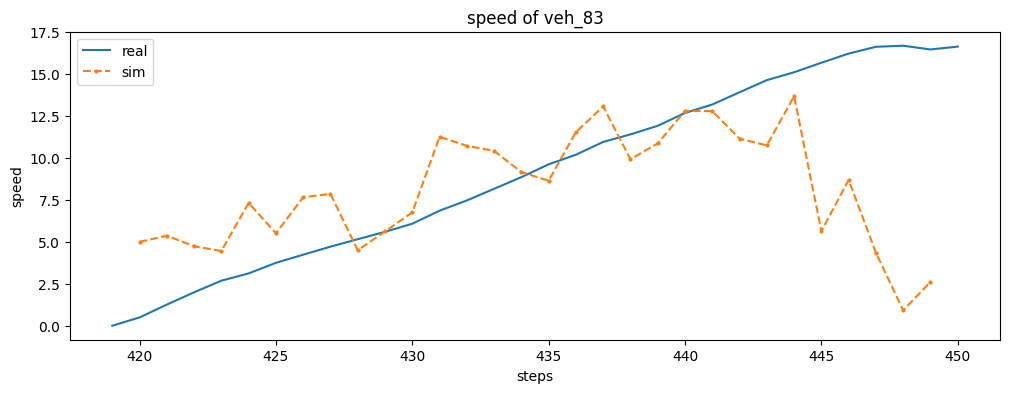

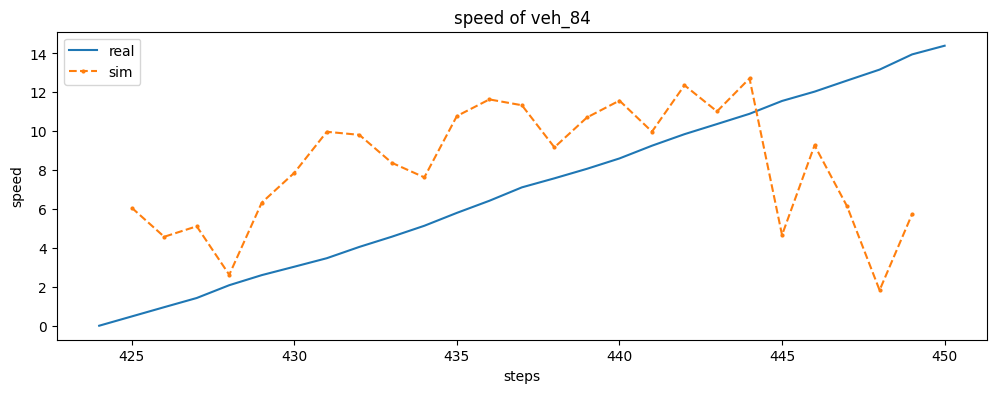

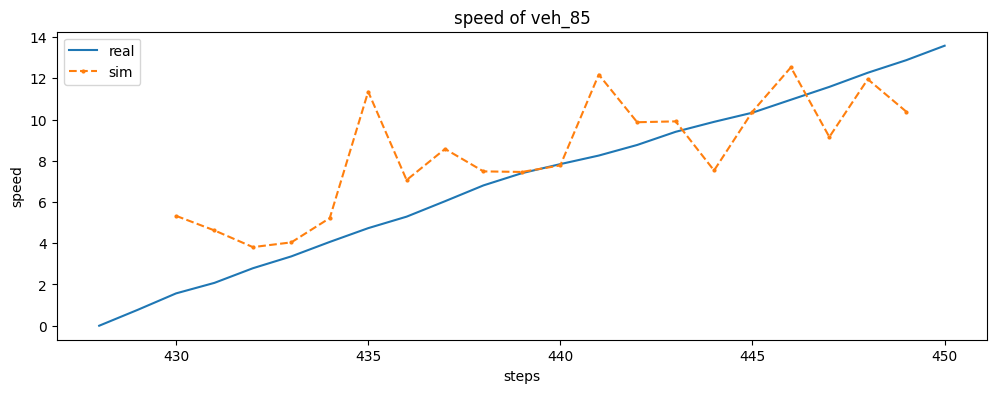

In [25]:
node_type = 'veh'
feat_name = 'speed'
for node_id in common_keys[1:]:
    plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)


/tmp/ipykernel_126971/3897183209.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))


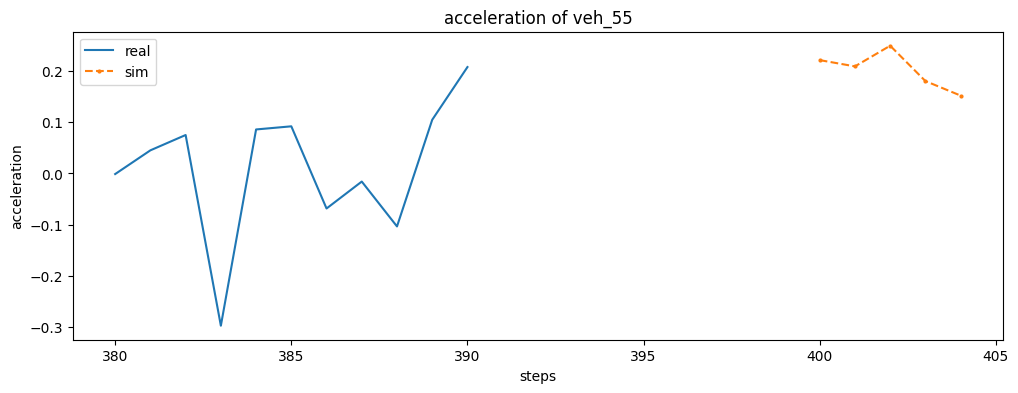

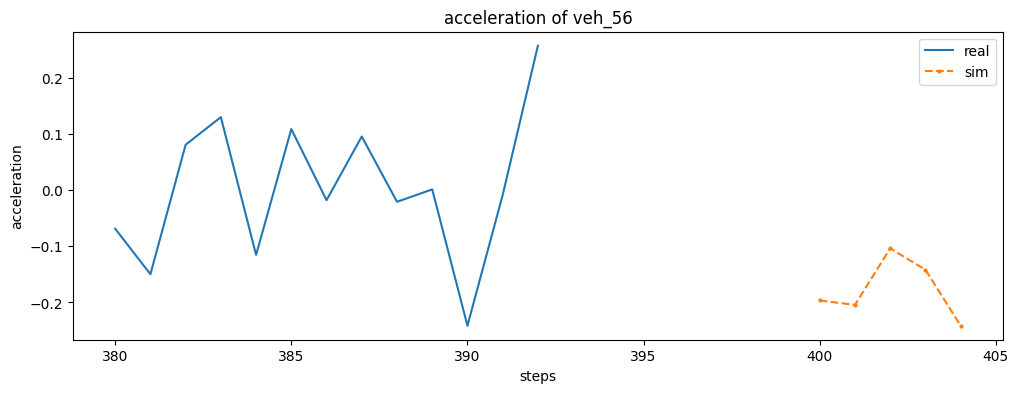

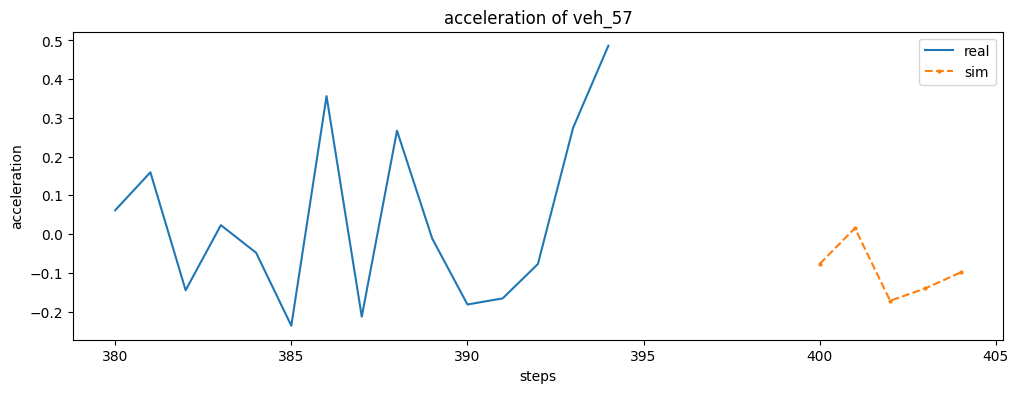

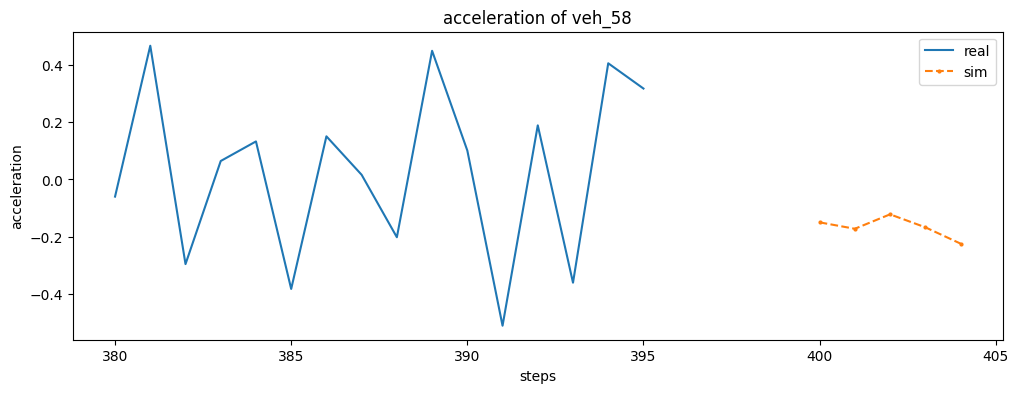

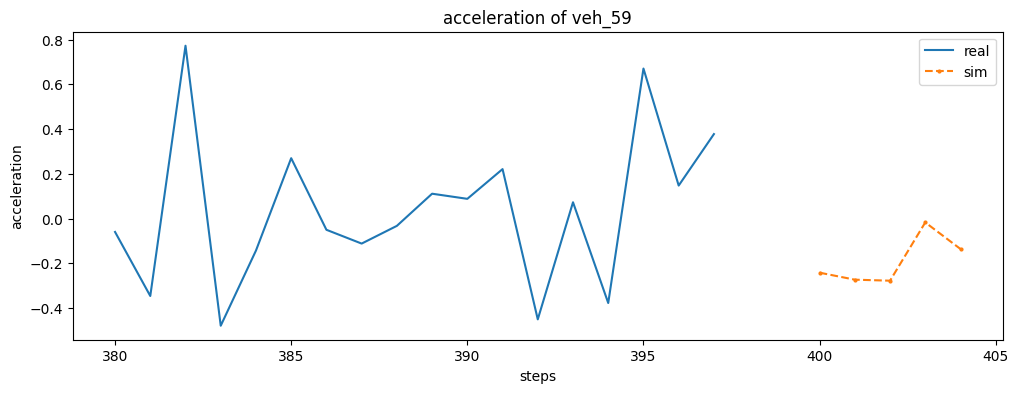

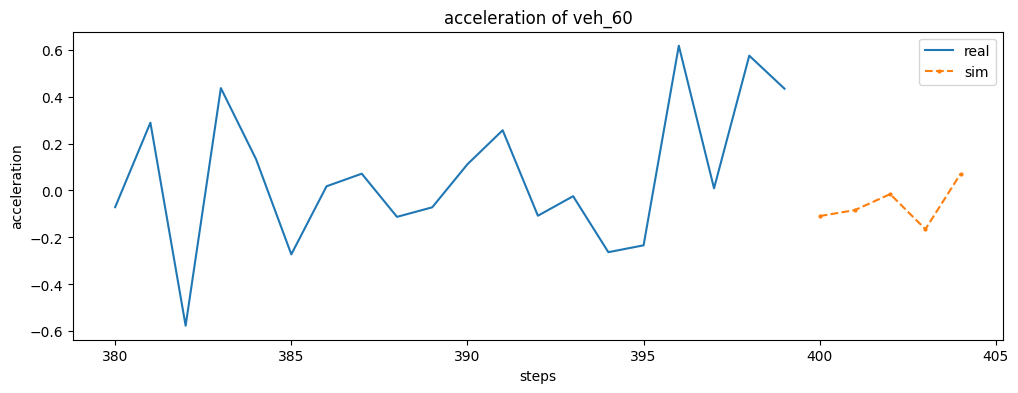

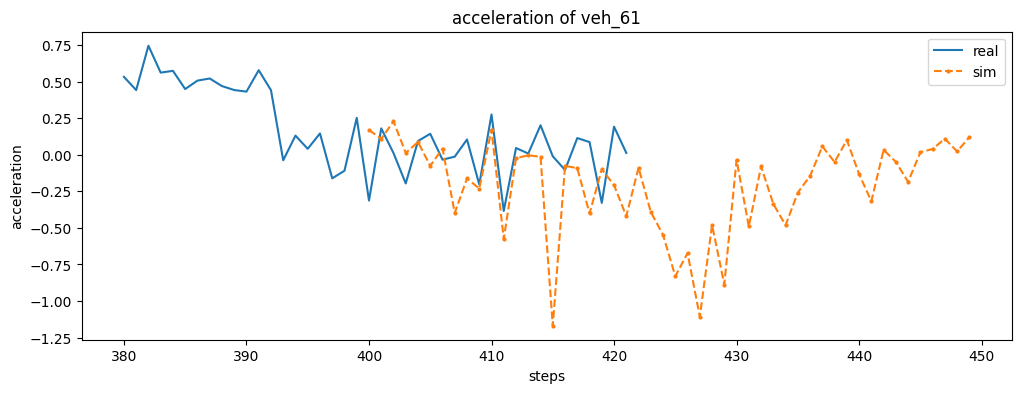

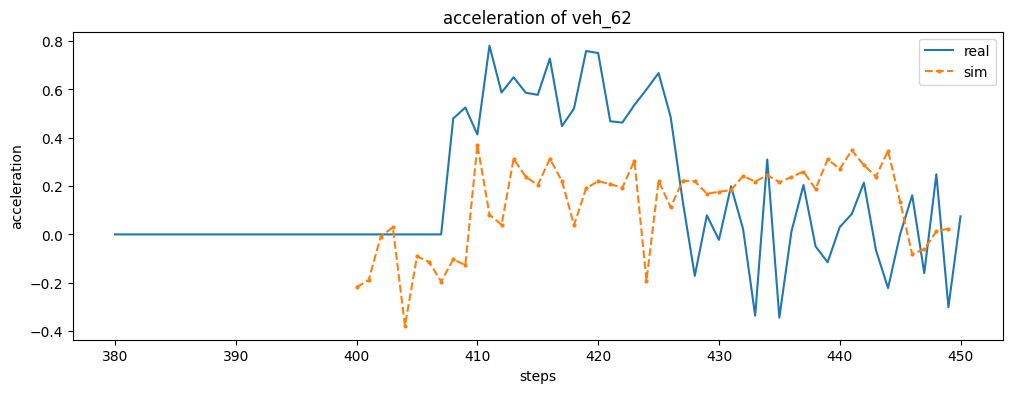

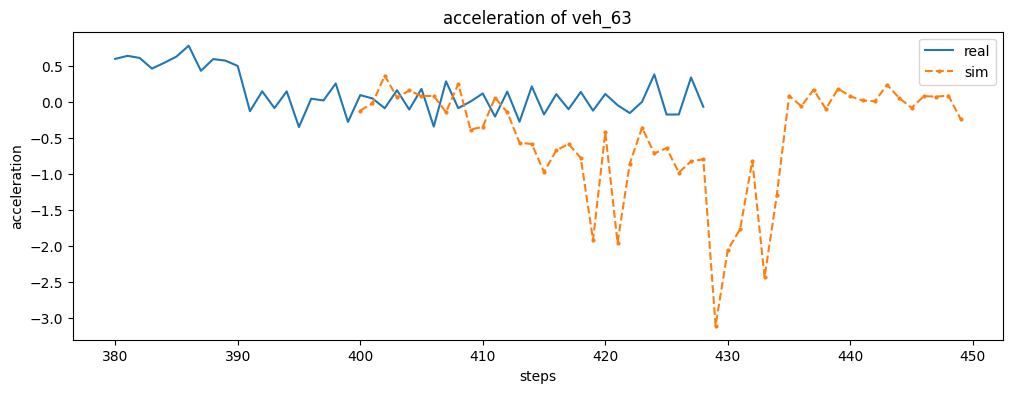

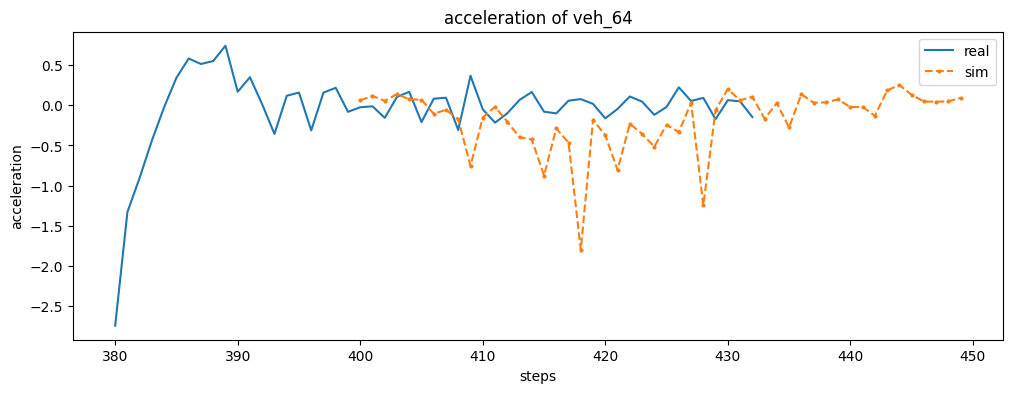

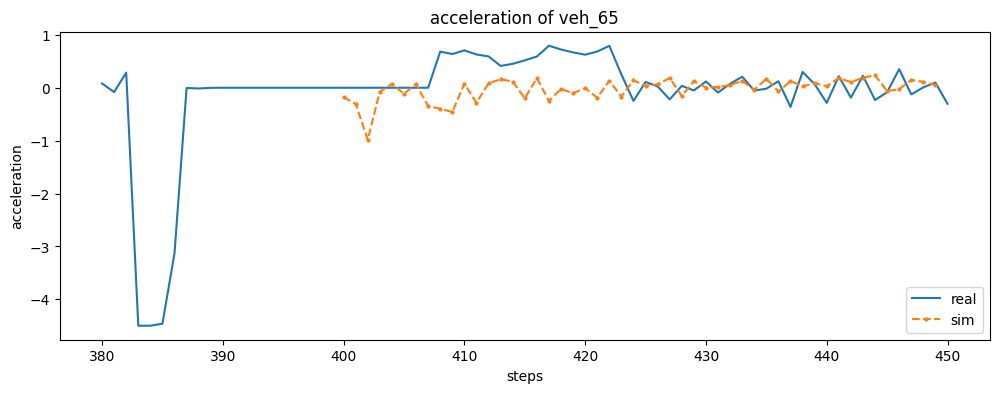

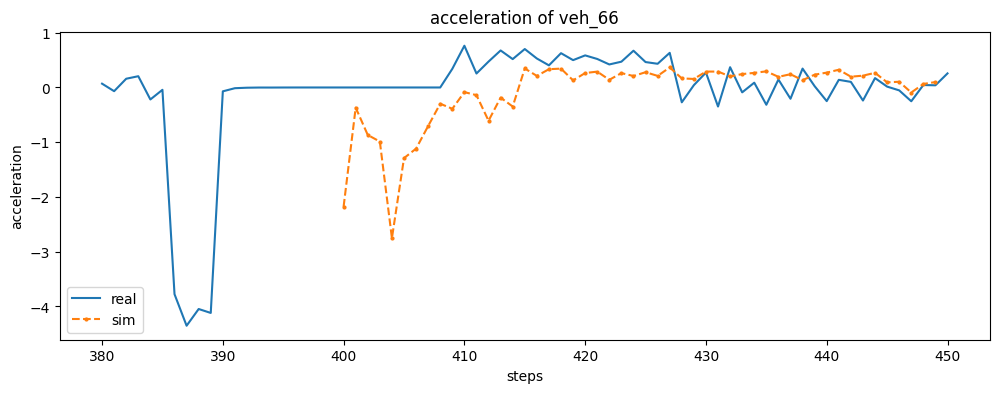

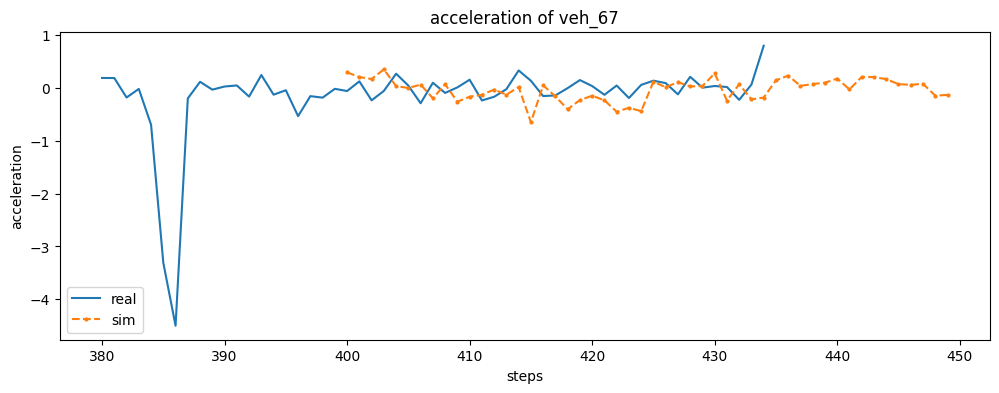

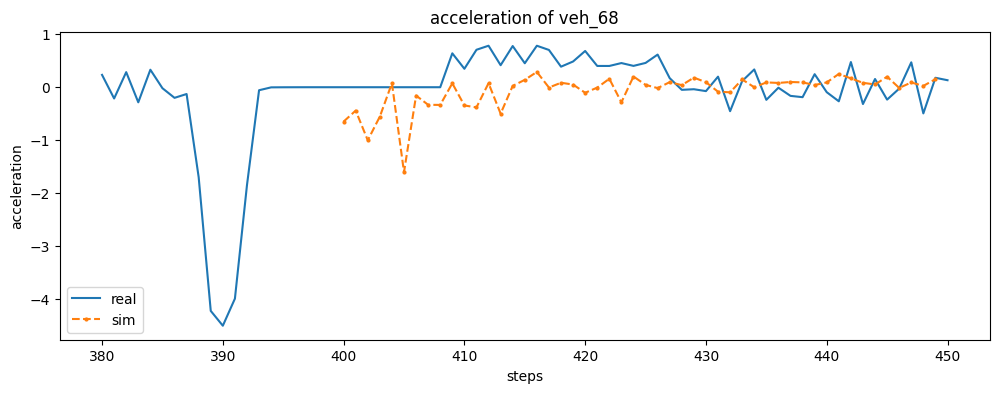

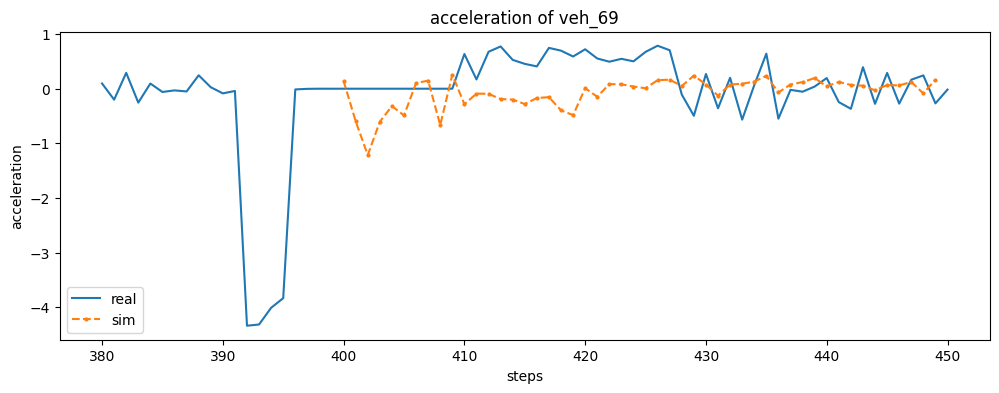

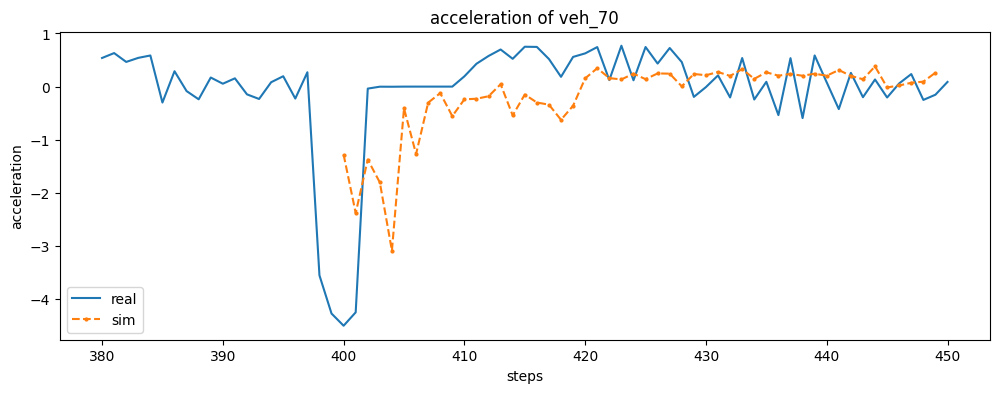

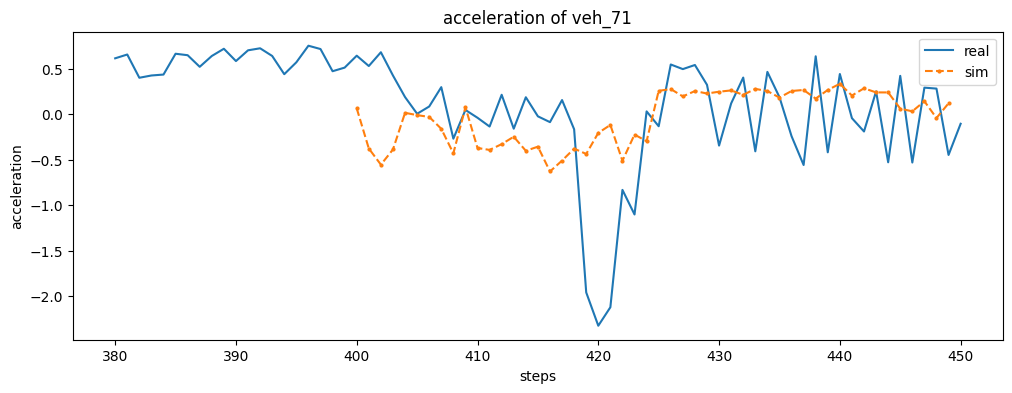

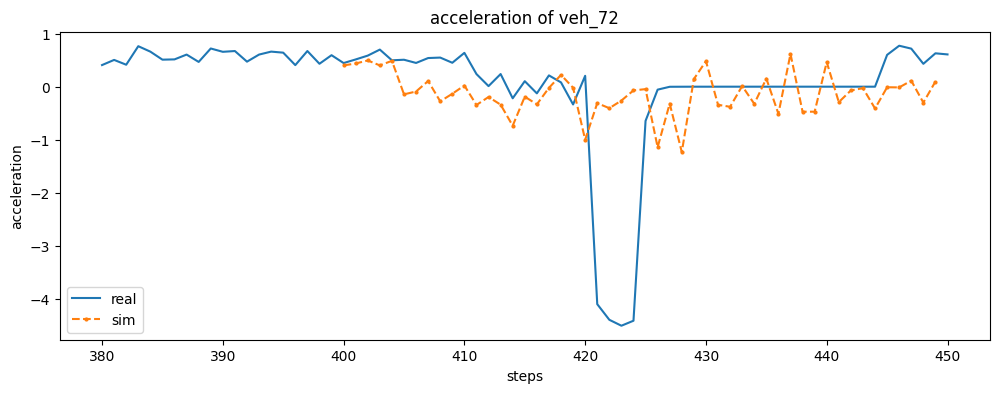

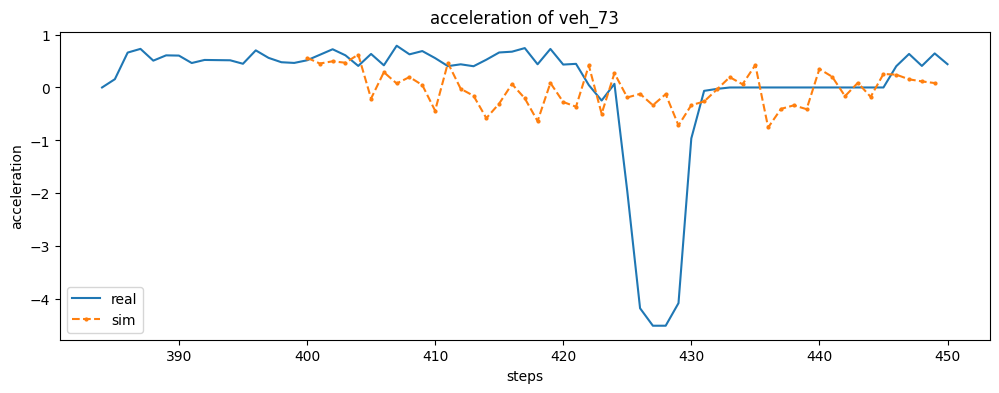

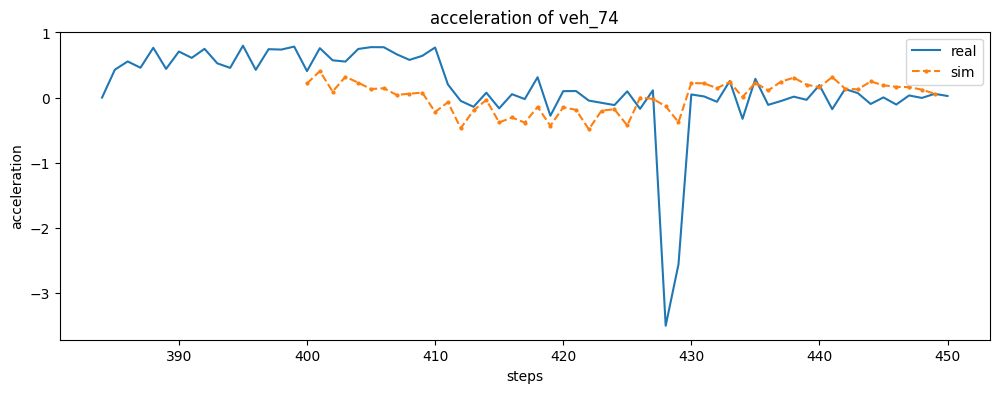

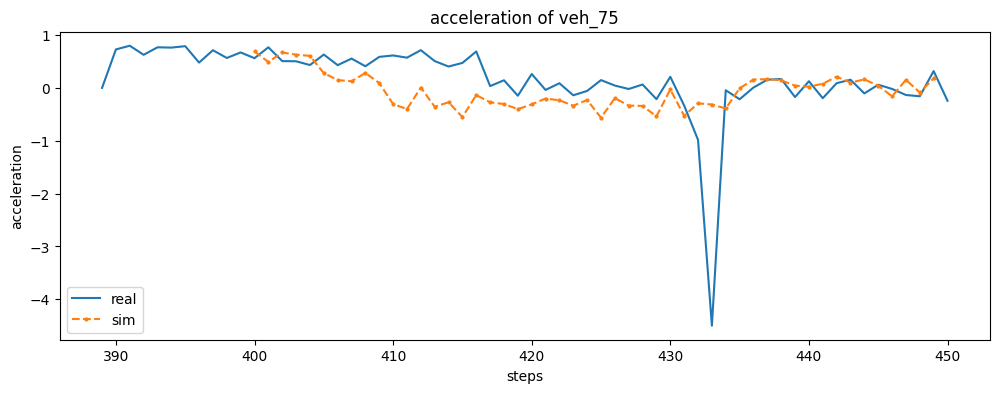

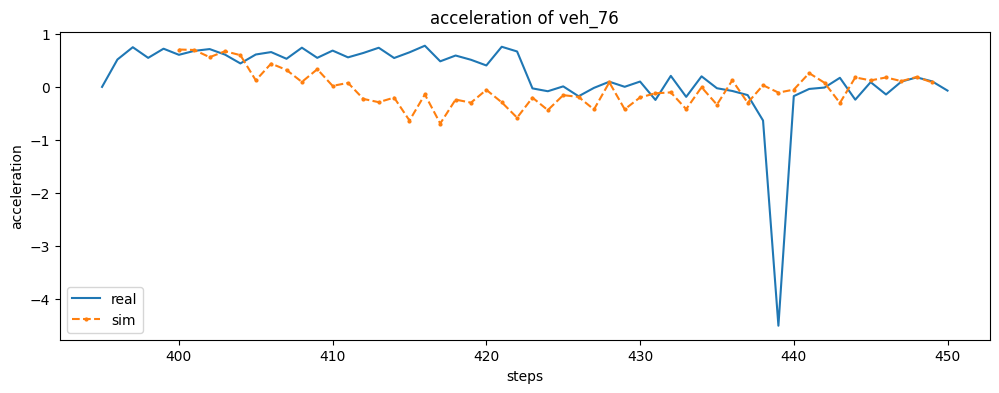

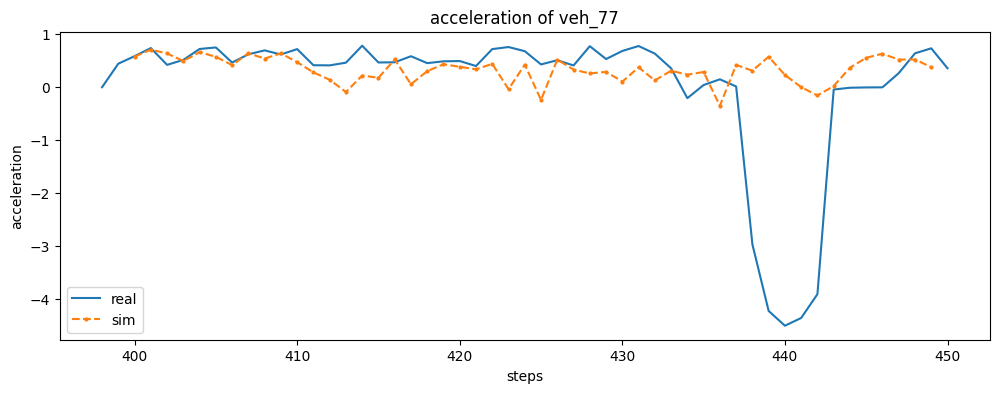

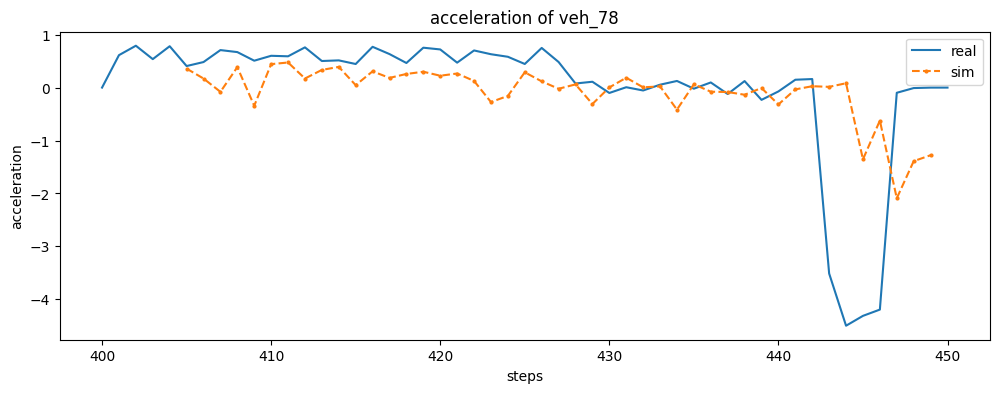

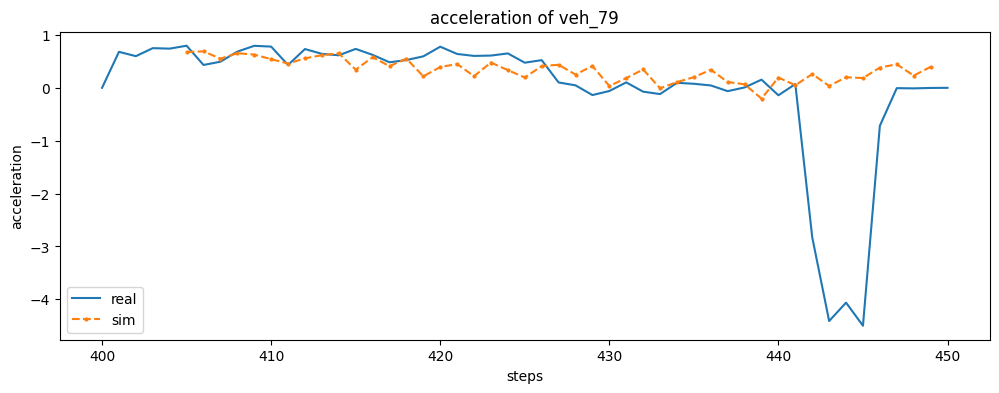

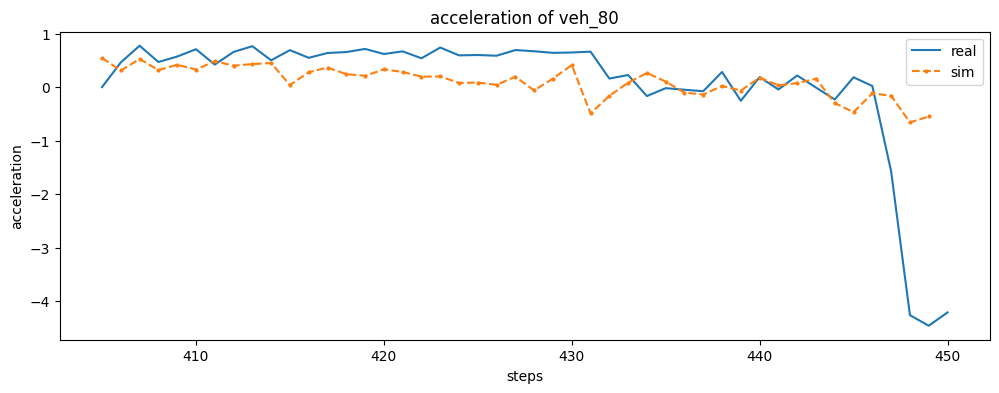

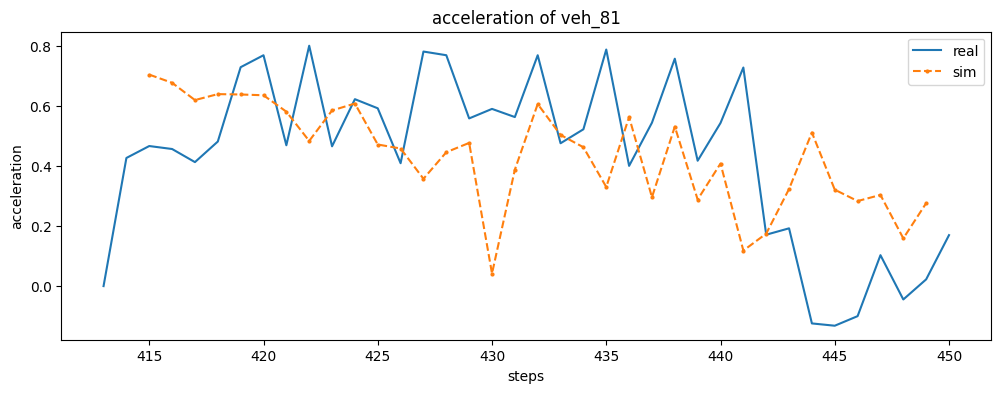

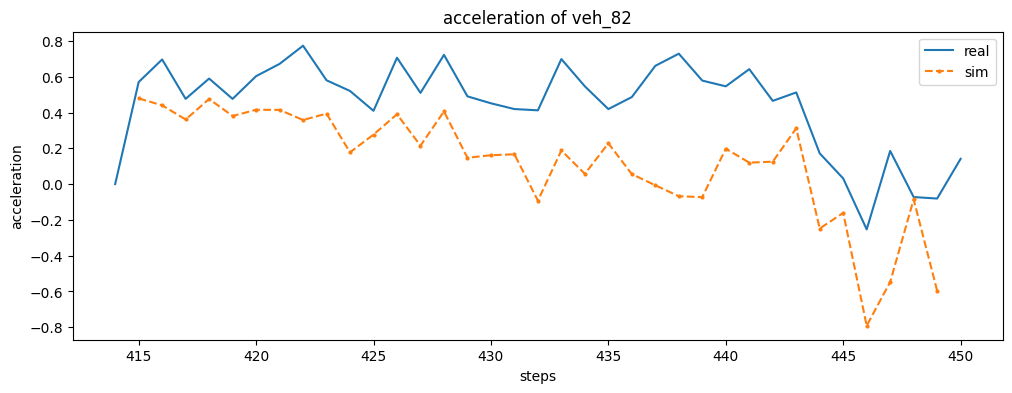

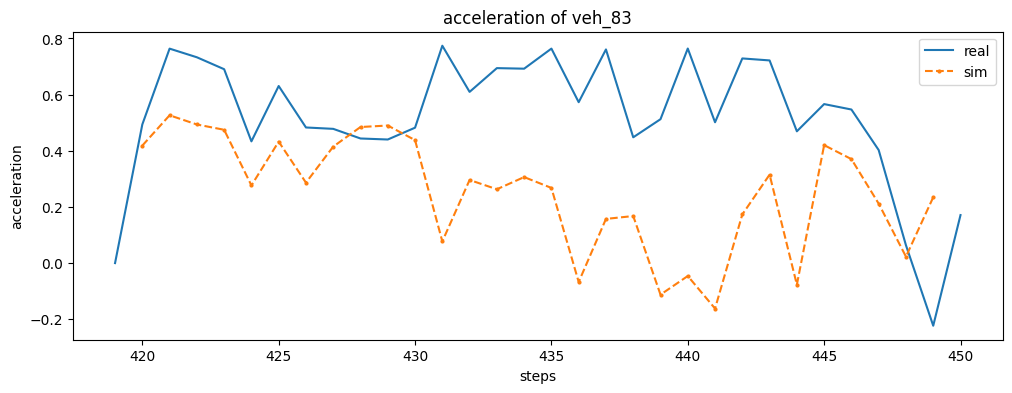

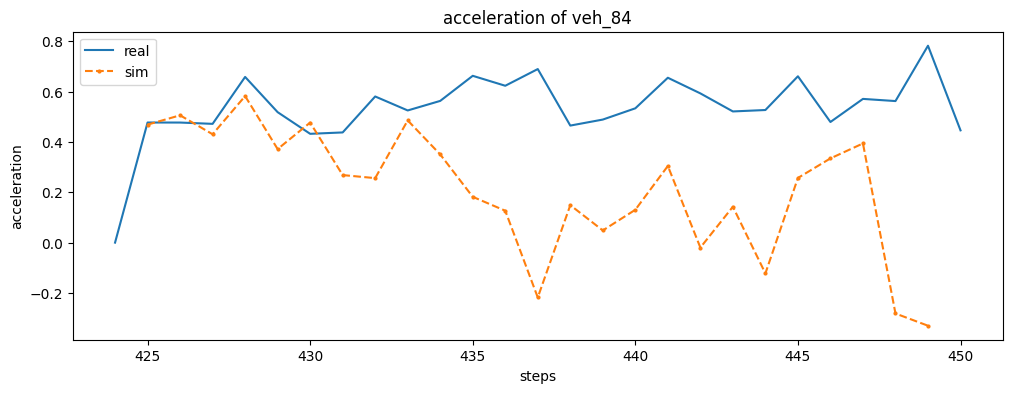

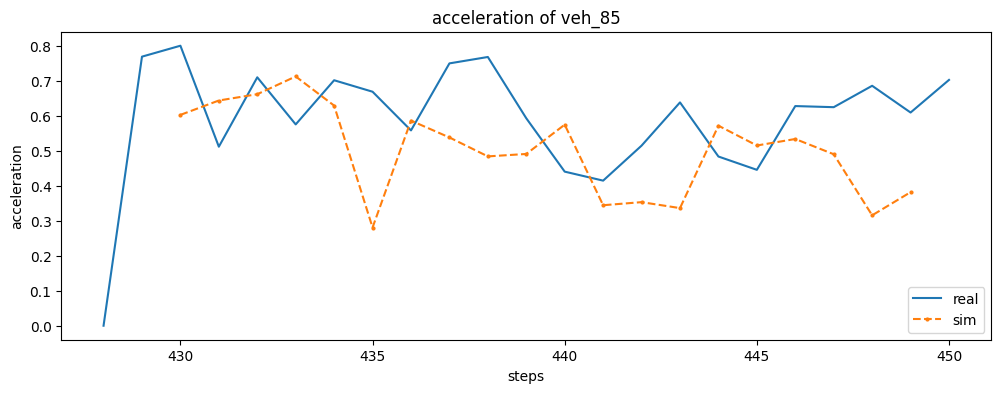

In [26]:
node_type = 'veh'
feat_name = 'acceleration'
for node_id in common_keys[1:]:
    plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)


### Plot feat for single time interval

In [27]:
def sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    feat_sim = get_feat_df(sim_feat, node_type, node_id, feat_name)
    pre_res = feat_real[feat_name+str(node_id)][:prev_step]
    sim_res = feat_sim[feat_name+str(node_id)]
    sim_res = pd.concat([pre_res, sim_res])[:(max(feat_real['time'])-min(feat_real['time']))]
    sim_time = pd.concat([feat_real['time'][:prev_step],feat_sim['time']])[:(max(feat_real['time'])-min(feat_real['time']))]
    return sim_time,sim_res
    

In [28]:

def plot_feat(real_feat, sim_feat, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    sim_time,sim_res = sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

    ax.plot(feat_real['time'],feat_real[feat_name+str(node_id)], linewidth=2, color='blue', label="SUMO")
    ax.plot(sim_time, sim_res, linestyle='--', linewidth=2, marker='o', markersize=6, color='red', label="TransWorld")
    ax.axvline(x=training_step, linestyle='--', linewidth=1, color='gray')

    ax.set_xlabel("Steps", fontsize=14)
    ax.set_ylabel(feat_name.capitalize(), fontsize=14)  # Capitalize the first letter of feat_name
    #ax.set_title(f"{feat_name.capitalize()} of {node_type}_{node_id}", fontsize=18)  # Capitalize the first letter of feat_name
 
    #ax.set_title(f"{feat_name} of {node_type}_{node_id}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

    text_x = max(feat_real['time'])
    text_y = min(feat_real[feat_name+str(node_id)])
    ax.text(text_x, text_y, f"Node type: {node_type}\nNode ID: {node_id}\nFeature name: {feat_name}\nTraining step: 0~{training_step}", fontsize=14, ha='right', va='bottom')

    # Add "Training" and "Evaluation" text
    text_y = max(feat_real[feat_name+str(node_id)])
    ax.text(training_step-5, text_y, "Training", fontsize=12, ha="right")
    ax.text(training_step+5, text_y, "Evaluation", fontsize=12, ha="left")

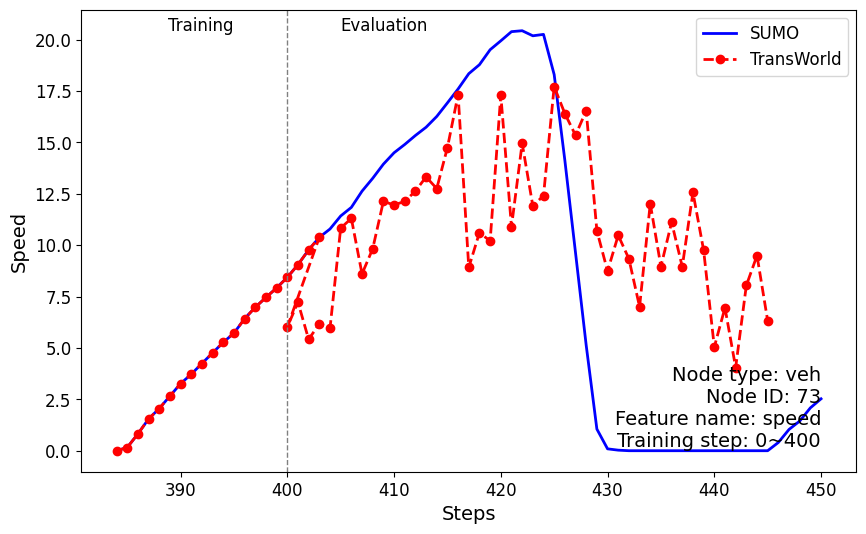

In [31]:
node_type = 'veh'
feat_name = 'speed'
node_id = 73

plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)

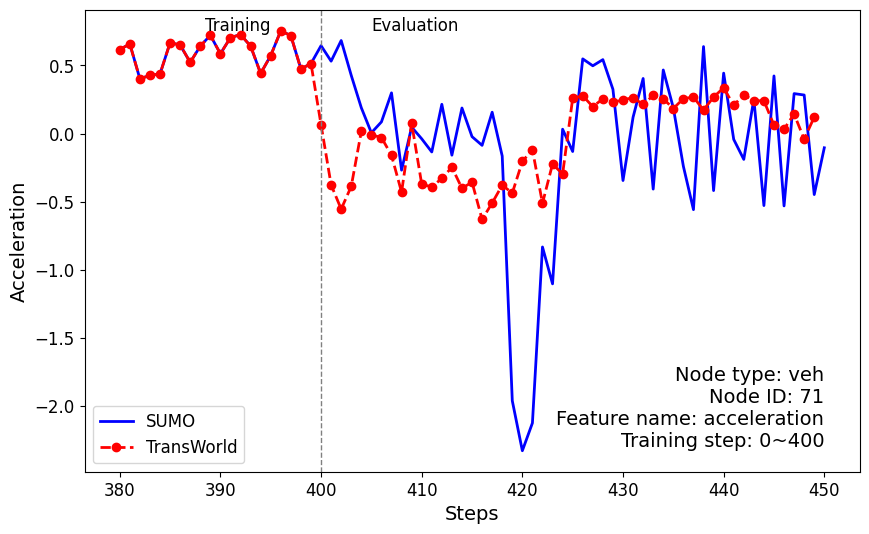

In [33]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 71

plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)

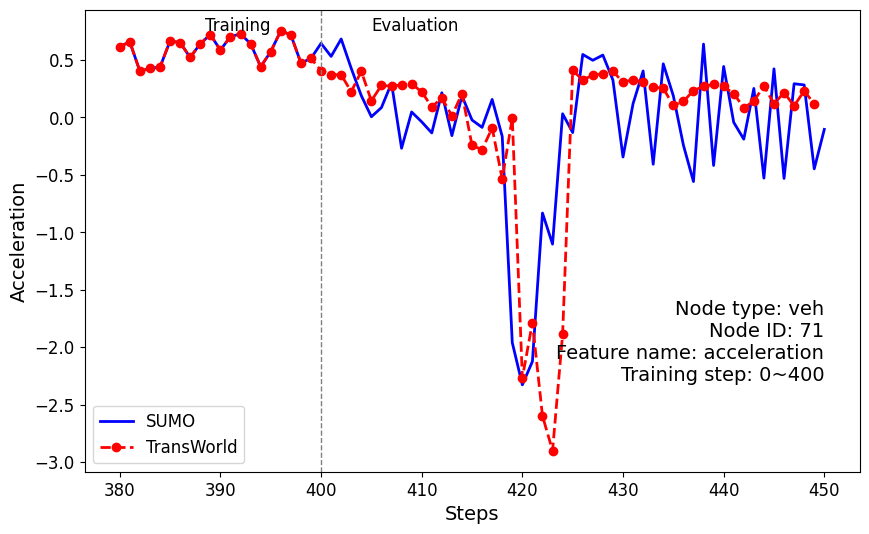

In [181]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 71

plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)

### Plot different time interval

In [5]:
def sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    feat_sim = get_feat_df(sim_feat, node_type, node_id, feat_name)
    pre_res = feat_real[feat_name+str(node_id)][:prev_step]
    sim_res = feat_sim[feat_name+str(node_id)]
    sim_res = pd.concat([pre_res, sim_res])[:(max(feat_real['time'])-min(feat_real['time']))]
    sim_time = pd.concat([feat_real['time'][:prev_step],feat_sim['time']])[:(max(feat_real['time'])-min(feat_real['time']))]
    return sim_time,sim_res
    

In [6]:
def plot_feat(real_feat, sim_feat_dict, node_type, node_id, feat_name, training_step):
    # Get dataframe of real feature values
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    
    # Initialize color and linestyle for simulated feature values
    sim_colors = ['green', 'red', 'purple', 'black']
    sim_linestyles = ['--', '-.', ':', ':']
    
    # Create subplots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
    
    # Plot real feature values
    ax.plot(feat_real['time'], feat_real[feat_name+str(node_id)], color='blue', linestyle='-', label='SUMO')
    
    # Plot simulated feature values for each simulation duration
    for i, (sim_feat, sim_color, sim_linestyle) in enumerate(zip(sim_feat_dict.values(), sim_colors, sim_linestyles)):
        sim_time, sim_res = sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name)
        ax.plot(sim_time, sim_res, color=sim_color, linestyle=sim_linestyle, marker='o', markersize=1, label=f'TransWorld (TI ={list(sim_feat_dict.keys())[i]} steps)')
    
    # Add vertical line for training step
    ax.axvline(x=training_step, linestyle='--', linewidth=1, color='gray')

    ax.set_xlabel("Steps", fontsize=14)
    ax.set_ylabel(feat_name.capitalize(), fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=10)

    # Add text for node type, node ID, feature name, and training step
    text_x = max(feat_real['time'])
    text_y = min(feat_real[feat_name+str(node_id)])
    ax.text(text_x, text_y, f"Node type: {node_type}\nNode ID: {node_id}\nFeature name: {feat_name}\nTraining step: 0~{training_step}", fontsize=14, ha='right', va='bottom')

    # Add "Training" and "Evaluation" text
    text_y = max(max(feat_real[feat_name+str(node_id)]), max(sim_res))
    ax.text(training_step-5, text_y, "Training", fontsize=12, ha="right")
    ax.text(training_step+5, text_y, "Evaluation", fontsize=12, ha="left")
    
    plt.show()


In [7]:


training_step = 400
pred_step = 5
prev_step = 20
case =  "traci_tls"
test = "test500"
out_pre = "out_dim_100_n_heads_4_n_layer_4_pred_step_"


In [8]:
real_data_dir = exp_dir / case / "data" / test / "test_data"
train_data_dir = exp_dir / case  / "data" / test / "train_data"
node_all = pd.read_csv(train_data_dir / "node_all.csv")
node_id_dict = generate_unique_node_id(node_all)

real_struc, real_feat, node_id_dict, scalers =  load_graph(real_data_dir,training_step-prev_step,training_step+pred_step*10,node_id_dict)
real_feat = unscale_feat(real_feat, scalers)

In [13]:
sim_feat_dict = {}

pred_steps = [5, 10, 50, 100]  # List of prediction steps

# Loop through each prediction step and load and unscale the simulated feature values
for pred_step in pred_steps:
    out = out_pre + str(pred_step)
    sim_feat = load_data(exp_dir, case, test, out, training_step, pred_step)
    sim_feat = unscale_feat(sim_feat, scalers)
    sim_feat_dict[pred_step] = sim_feat


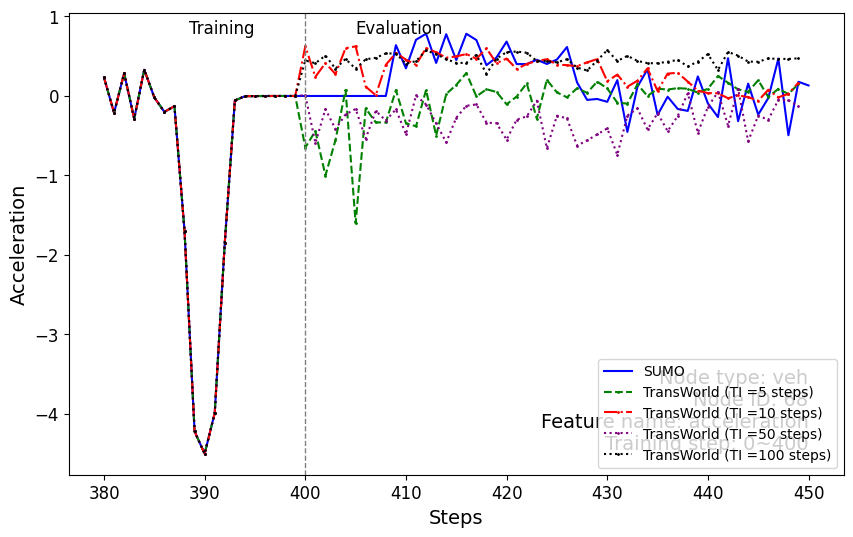

In [14]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 68
#for node_id in sim_feat_2['veh'].keys():

plot_feat(real_feat, sim_feat_dict, node_type, node_id, feat_name, training_step)

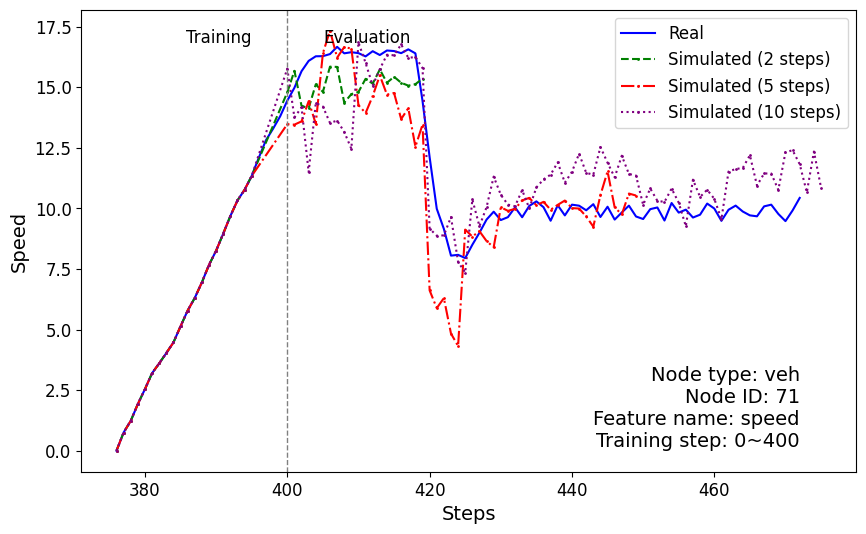

In [207]:
node_type = 'veh'
feat_name = 'speed'
node_id = 71
#for node_id in sim_feat_2['veh'].keys():

plot_feat(real_feat, sim_feat_2, sim_feat_5, sim_feat_10, node_type, node_id, feat_name)